# Notebook 06: Clustering Ablation (Behavioral Features Only)

This notebook tests one focused hypothesis:

If aisle-heavy features add too much sparsity/noise, clustering quality should improve when we keep only compact behavioral features.


---

## Setup + Runtime Config

In [1]:
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

SKIP_K2 = False
USE_MINIBATCH_FOR_FULL_FIT = True
K_RANGE = list(range(2, 11))
GRID_SAMPLE_N = 60000
EVAL_SAMPLE_N = 25000
WINSOR_LO = 0.005
WINSOR_HI = 0.995

INPUT_PATH = Path('data/features/feature_matrix.parquet')
ALL_METRICS_PATH = Path('data/clusters/ablation_all_features/clustering_metrics_all_features.csv')
BASELINE_PATH = Path('data/clusters/clustering_metrics.csv')
OUTPUT_DIR = Path('data/clusters/ablation_non_aisle_features')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print('Runtime config loaded.')


Runtime config loaded.


---

## 1) Build Non-Aisle Matrix

In [2]:
features = pd.read_parquet(INPUT_PATH).copy()
all_cols = list(features.columns)
aisle_cols = [c for c in all_cols if c.lower().startswith('aisle_')]
non_aisle_cols = [c for c in all_cols if not c.lower().startswith('aisle_')]

subset = features[non_aisle_cols].copy()

print('Feature split:')
print(f'  all features: {len(all_cols)}')
print(f'  aisle features removed: {len(aisle_cols)}')
print(f'  non-aisle features kept: {len(non_aisle_cols)}')
print(f'  subset shape: {subset.shape}')

missing = int(subset.isna().sum().sum())
inf = int(np.isinf(subset.values).sum())
print(f'  missing values: {missing}')
print(f'  inf values: {inf}')

assert len(non_aisle_cols) > 0, 'No non-aisle columns detected.'
assert missing == 0, 'Missing values found in non-aisle matrix.'
assert inf == 0, 'Infinite values found in non-aisle matrix.'


Feature split:
  all features: 149
  aisle features removed: 135
  non-aisle features kept: 14
  subset shape: (182223, 14)
  missing values: 0
  inf values: 0


---

## 2) Preprocess (Winsorize + Scale)

In [3]:
q_lo = subset.quantile(WINSOR_LO)
q_hi = subset.quantile(WINSOR_HI)
X_clipped = subset.clip(lower=q_lo, upper=q_hi, axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X_clipped.values)
user_ids = subset.index.to_numpy()

print('Preprocessing complete:')
print(f'  X shape: {X.shape}')
print(f'  mean(abs): {np.abs(X.mean(axis=0)).mean():.4e}')
print(f'  std(avg): {X.std(axis=0).mean():.4f}')


Preprocessing complete:
  X shape: (182223, 14)
  mean(abs): 1.8992e-16
  std(avg): 1.0000


---

## 3) K Search on Sample

In [4]:
sample_n = min(GRID_SAMPLE_N, len(X))
sample_idx = rng.choice(len(X), sample_n, replace=False)
X_grid = X[sample_idx]

rows = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10, max_iter=300)
    labels = km.fit_predict(X_grid)

    sil = float(silhouette_score(X_grid, labels))
    ch = float(calinski_harabasz_score(X_grid, labels))
    db = float(davies_bouldin_score(X_grid, labels))
    sizes = Counter(labels)
    min_pct = float(min(sizes.values()) / len(labels) * 100)
    max_pct = float(max(sizes.values()) / len(labels) * 100)

    rows.append({
        'k': k,
        'silhouette': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db,
        'min_cluster_pct': min_pct,
        'max_cluster_pct': max_pct,
    })
    print(f'k={k}: silhouette={sil:.3f}, min_cluster={min_pct:.1f}%')

results_df = pd.DataFrame(rows).sort_values(['silhouette', 'min_cluster_pct'], ascending=[False, False]).reset_index(drop=True)
results_df.to_csv(OUTPUT_DIR / 'k_search_non_aisle.csv', index=False)

print('\nTop candidates:')
print(results_df.head(8).to_string(index=False))


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  cu

k=2: silhouette=0.194, min_cluster=38.3%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=3: silhouette=0.155, min_cluster=31.7%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=4: silhouette=0.148, min_cluster=16.2%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=5: silhouette=0.138, min_cluster=13.7%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=6: silhouette=0.132, min_cluster=12.5%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=7: silhouette=0.129, min_cluster=9.3%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=8: silhouette=0.124, min_cluster=6.9%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=9: silhouette=0.119, min_cluster=6.5%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=10: silhouette=0.116, min_cluster=5.7%

Top candidates:
 k  silhouette  calinski_harabasz  davies_bouldin  min_cluster_pct  max_cluster_pct
 2    0.194446       15965.234905        1.803359        38.270000        61.730000
 3    0.154887       12648.828764        1.957893        31.701667        36.036667
 4    0.148151       10940.766171        1.939808        16.181667        31.310000
 5    0.138499        9823.309170        1.892003        13.656667        26.861667
 6    0.132320        9086.134578        1.783157        12.486667        24.078333
 7    0.129282        8394.797943        1.765419         9.296667        21.735000
 8    0.123752        7791.438186        1.764689         6.936667        20.038333
 9    0.118836        7355.833030        1.756654         6.535000        16.301667


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

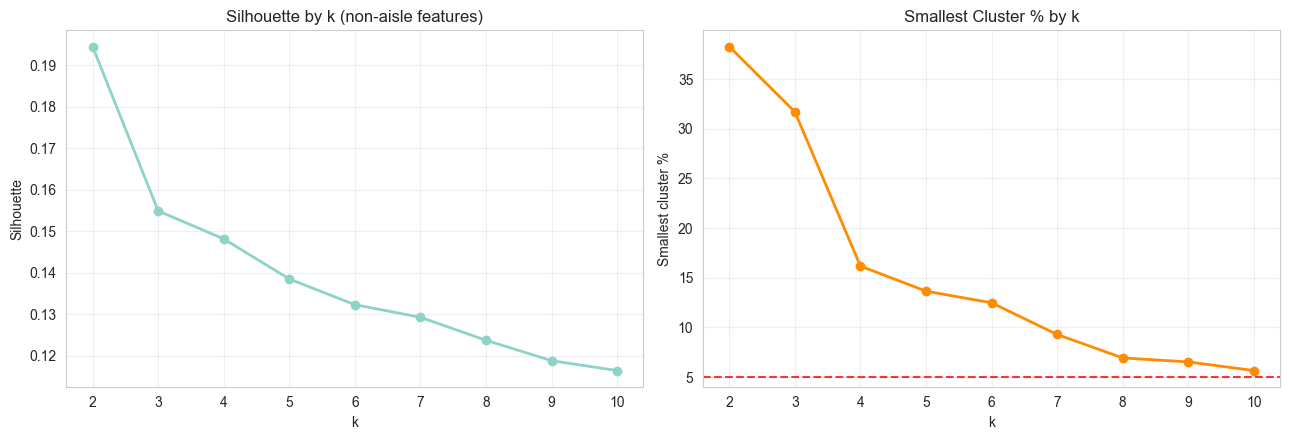

In [5]:
plot_df = results_df.sort_values('k')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

axes[0].plot(plot_df['k'], plot_df['silhouette'], marker='o', linewidth=2)
axes[0].set_title('Silhouette by k (non-aisle features)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Silhouette')
axes[0].grid(alpha=0.3)

axes[1].plot(plot_df['k'], plot_df['min_cluster_pct'], marker='o', linewidth=2, color='darkorange')
axes[1].axhline(5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
axes[1].set_title('Smallest Cluster % by k')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Smallest cluster %')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'k_search_non_aisle.png', dpi=150, bbox_inches='tight')
plt.show()


---

## 4) Select k + Fit Final Model

In [6]:
if SKIP_K2:
    candidates = results_df[results_df['k'] > 2].reset_index(drop=True)
    best = candidates.iloc[0] if len(candidates) > 0 else results_df.iloc[0]
else:
    best = results_df.iloc[0]

optimal_k = int(best['k'])
print(f'Chosen k: {optimal_k}')
print(f"Grid silhouette: {best['silhouette']:.4f}")

if USE_MINIBATCH_FOR_FULL_FIT:
    final_model = MiniBatchKMeans(
        n_clusters=optimal_k,
        random_state=RANDOM_SEED,
        batch_size=4096,
        n_init=10,
        max_iter=300,
    )
else:
    final_model = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED, n_init=10, max_iter=300)

final_labels = final_model.fit_predict(X)
sizes = Counter(final_labels)
min_pct_full = float(min(sizes.values()) / len(final_labels) * 100)

eval_n = min(EVAL_SAMPLE_N, len(X))
eval_idx = rng.choice(len(X), eval_n, replace=False)
X_eval = X[eval_idx]
y_eval = final_labels[eval_idx]

final_sil = float(silhouette_score(X_eval, y_eval))
final_ch = float(calinski_harabasz_score(X_eval, y_eval))
final_db = float(davies_bouldin_score(X_eval, y_eval))

print('Final metrics (sampled eval):')
print(f'  silhouette: {final_sil:.4f}')
print(f'  calinski_harabasz: {final_ch:.2f}')
print(f'  davies_bouldin: {final_db:.4f}')
print(f'  smallest cluster %: {min_pct_full:.2f}')

pd.DataFrame({'user_id': user_ids, 'cluster': final_labels}).to_parquet(
    OUTPUT_DIR / 'cluster_labels_non_aisle.parquet', index=False
)
pd.DataFrame(final_model.cluster_centers_, columns=subset.columns).to_csv(
    OUTPUT_DIR / 'cluster_centers_non_aisle.csv', index=False
)

metrics_df = pd.DataFrame([{
    'feature_set': 'non_aisle_features',
    'n_features': int(X.shape[1]),
    'n_clusters': int(optimal_k),
    'silhouette_score': final_sil,
    'calinski_harabasz': final_ch,
    'davies_bouldin': final_db,
    'smallest_cluster_pct': min_pct_full,
    'k2_skipped': bool(SKIP_K2),
    'grid_sample_n': int(sample_n),
    'eval_sample_n': int(eval_n),
    'winsor_lo': float(WINSOR_LO),
    'winsor_hi': float(WINSOR_HI),
    'algo_full_fit': type(final_model).__name__,
}])
metrics_df.to_csv(OUTPUT_DIR / 'clustering_metrics_non_aisle.csv', index=False)

print('\nSaved outputs in:')
print(f'  {OUTPUT_DIR}')


Chosen k: 2
Grid silhouette: 0.1944


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  cu

Final metrics (sampled eval):
  silhouette: 0.1910
  calinski_harabasz: 6641.89
  davies_bouldin: 1.8220
  smallest cluster %: 40.56

Saved outputs in:
  data/clusters/ablation_non_aisle_features


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

---

## 5) Compare All Three Approaches

                 approach  n_features  silhouette  k
   04c_non_aisle_features        14.0    0.190983  2
notebook_04_pruned_matrix         NaN    0.104910  3
         04b_all_features       149.0   -0.008005  3


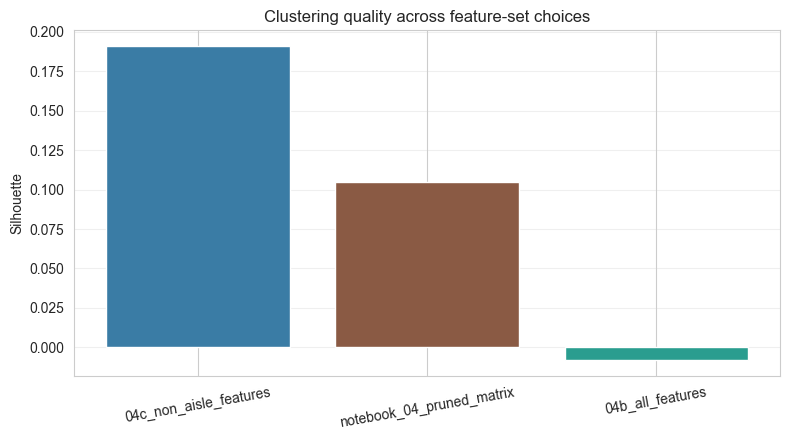

In [7]:
rows = []

if BASELINE_PATH.exists():
    b = pd.read_csv(BASELINE_PATH).iloc[0]
    rows.append({
        'approach': 'notebook_04_pruned_matrix',
        'n_features': np.nan,
        'silhouette': float(b['silhouette_score']),
        'k': int(b['n_clusters'])
    })

if ALL_METRICS_PATH.exists():
    a = pd.read_csv(ALL_METRICS_PATH).iloc[0]
    rows.append({
        'approach': '04b_all_features',
        'n_features': int(a['n_features']),
        'silhouette': float(a['silhouette_score']),
        'k': int(a['n_clusters'])
    })

rows.append({
    'approach': '04c_non_aisle_features',
    'n_features': int(metrics_df.iloc[0]['n_features']),
    'silhouette': float(metrics_df.iloc[0]['silhouette_score']),
    'k': int(metrics_df.iloc[0]['n_clusters'])
})

cmp_df = pd.DataFrame(rows)
cmp_df = cmp_df.sort_values('silhouette', ascending=False).reset_index(drop=True)
cmp_df.to_csv(OUTPUT_DIR / 'approach_comparison.csv', index=False)

print(cmp_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(cmp_df['approach'], cmp_df['silhouette'], color=['#3A7CA5', '#8A5A44', '#2A9D8F'][:len(cmp_df)])
ax.set_ylabel('Silhouette')
ax.set_title('Clustering quality across feature-set choices')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=10)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'approach_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## Wrap-up Notes

This is the strongest unsupervised variant in the project so far.

- Best run: `k=2`, silhouette around `0.19` (with `SKIP_K2=False`).
- Clear lift versus Notebook 04 baseline (~`0.10`).
- Much better than all-feature ablation (`05`, negative silhouette).
- Still not enough separation for sharp, high-confidence personas.

How to present this:
- Use Notebook 06 as proof that non-aisle behavioral features carry the cleanest clustering signal.
- Describe clusters as broad behavior groups, not rigid archetypes.
- Use Notebook 07 for final operational segmentation.
